## Normalization trick for PDHG

We model the measurement with the following process:

$b\sim\eta\operatorname{Pois}(\frac{Ax}{\eta}+r)$

- $A$: Forward
- $\eta$: Scaling factor/noise level
- $r$: Background 

We consider the following problem:

$\min_x KL(Ax,b)+\lambda\|\nabla x\|_{2,1}+\delta_{x\geq0}(x)$

- $KL(Ax,b) = \mathbf{1}^T(\tilde{A}x+r-\tilde{b})+\tilde{b}^T\log(\tilde{b})-\tilde{b}^T\log(\tilde{A}x+r)$
- $\tilde{A}=\frac{A}{\eta}$, $\tilde{b}=\frac{b}{\eta}$ 

To cast it into primal-dual framework, we consider:

$\min_xf_1(K_1x)+f_2(K_2x)+g(x)$

- $f_1(u_1)=\mathbf{1}^T(u_1+r-\tilde{b})+\tilde{b}^T\log(\tilde{b})-\tilde{b}^T\log(u_1+r)$
- $K_1=\tilde{A}$
- $f_2(u_2)=\lambda\|u_2\|_{2,1}$
- $K_2=\nabla$
- $g(x)=\delta_{x\geq0}(x)$


### Rescaling the operator

Considering scaled operators and function, the above problem is equivalent to:

$\min_x\tilde{f}_1(\tilde{K}_1x)+\tilde{f}_2(\tilde{K}_2x)+g(x)$

- $\tilde{f}_1(u_1)=f_1(\|K_1\|u_1)$
- $\tilde{K}_1=\frac{K_1}{\|K_1\|}$
- $\tilde{f}_2(u_2)=f_2(\|K_2\|u_2)$
- $\tilde{K}_2=\frac{K_2}{\|K_2\|}$


#### Key proximal operator formulae
We need to compute $\operatorname{prox}^{\sigma}_{\tilde{f}^*_i}$

Let's consider a function $h(u)=\phi(au)$, where $a>0$.

We have:

$\operatorname{prox}^{\sigma}_{h}(u)=\operatorname{prox}^{\sigma a^2}_{\phi}(au)/a$

Applying Moreau decomposition, we have:
$\operatorname{prox}^{\sigma}_{h^*}(u)=a\operatorname{prox}^{\sigma a^{-2}}_{\phi^*}(u/a)$

### Set up problem

In [70]:
import torch
import numpy as np
from deepinv.physics import Tomography, PoissonNoise
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load Phantom
phantom = torch.load('phantom.npy').to(device)

#Define Operator
noise_level = 1/10
background_lv = 5/noise_level
phantom = torch.load('phantom.npy').to(device)
gain = noise_level
physics = Tomography(
    angles=200,
    img_width=512,
    circle=False,
    device=device,
    noise_model= PoissonNoise(gain=gain,normalize=True),
)

#Simulate data and FBP
data_clean = physics.A(phantom)
background = background_lv*torch.ones_like(data_clean)
data = noise_level*torch.poisson(data_clean/noise_level+background)
data_denorm = data / noise_level
fbp = physics.A_dagger(data)
x_init = fbp.detach().clone()


#Def Discrete Grad
def D(img_in):
    B = img_in.shape[0]
    C = img_in.shape[1]
    N = img_in.shape[-1]
    N_d = 2

    D_img = torch.zeros([B, N_d, C, N, N]).to(device)
    # The intensity differences across rows (Upwind / Forward)
    D_img[:, 0, :, :-1, :] = img_in[:, :, 1:, :] - img_in[:, :, :-1, :]

    # The intensity differences across columns (Upwind / Forward)
    D_img[:, 1, :, :, :-1] = img_in[:, :, :, 1:] - img_in[:, :, :, :-1]

    return D_img

#Adjoint
def DT(D_img_in):
    B = D_img_in.shape[0]
    C = D_img_in.shape[2]
    N = D_img_in.shape[-1]

    D_T_img = torch.zeros([B, C, N, N]).to(device)

    # Forward row term
    D_T_img[:,:,1:,:] += D_img_in[:,0,:,:-1,:]
    D_T_img[:,:,:-1,:] += -D_img_in[:,0,:,:-1,:]

    # # Forward col term
    D_T_img[:,:,:,1:] += D_img_in[:,1,:,:,:-1]
    D_T_img[:,:,:,:-1] += -D_img_in[:,1,:,:,:-1]

    return(D_T_img)

#Total Variation Regularization
def TV_reg(img_in):
    D_img = D(img_in)
    return  torch.sum(torch.sqrt(torch.sum(D_img**2, dim=1)))

#Set up data fidelity
def data_function(x_in,data_in):
    exp = physics.A(x_in) / noise_level + background
    data_denorm = data_in / noise_level
    res = exp-data_denorm+data_denorm*torch.log(data_denorm)-data_denorm*torch.log(exp)
    id = (data_in == 0)
    res[id] = exp[id] - data_denorm[id]
    return float(torch.sum(res))

### Estimating operator norms



In [71]:
#Power method
def power(K_op,K_op_T,x_in):
    xk = x_in
    ss = []
    las = 1
    while True:
        Kxk = K_op(xk)
        xk = K_op_T(Kxk)
        xk = xk/torch.sqrt(torch.sum(xk**2))
        Kxk = K_op(xk)
        s = torch.sqrt(torch.sum(Kxk**2)).item()
        ss.append(s)
        if las > 1:
            if (ss[-1] - ss[-2])**2/ss[-2]**2 < 1e-6:
                break
        las += 1    
    return s

lmbd = 100.0
Anorm = torch.sqrt(physics.compute_norm(phantom))/noise_level
Dnorm = power(D,DT,phantom)

Power iteration converged at iteration 13, value=98873.61


### Vanilla PDHG

In [72]:
#Run PDHG (vanilla)

gammas = [0.1,0.5,1,5,10,50,100]
rho = 1.3
num_iter = 500
obj_pdhg = torch.zeros((len(gammas), num_iter+1))
pdhg_x100 = []
pdhg_x = []

print('PDHG vanilla')

for ig, gamma in enumerate(gammas):
    x_pdhg = x_init.clone()
    x_old = x_pdhg.clone()
    x_bar = 2*x_pdhg - x_old
    y_A = 1 - data_denorm / (physics.A(x_pdhg)/noise_level + background)
    y_D = torch.zeros_like(D(x_pdhg))
    print(f'\ngamma={gamma}')
    #Step-sizes
    sigma_A = gamma*rho/Anorm
    sigma_D = gamma*rho/Dnorm
    tau_A = rho/(gamma*Anorm)
    tau_D = rho/(gamma*Dnorm)
    tau = torch.minimum(torch.tensor(tau_A), torch.tensor(tau_D))

    loss = data_function(x_pdhg, data)+ lmbd*TV_reg(x_pdhg)
    obj_pdhg[ig,0] = loss

    for i in range(num_iter):
        y_A_plus = y_A + sigma_A * (physics.A(x_bar) / noise_level + background)
        y_A = 0.5 * (y_A_plus + 1 - torch.sqrt((y_A_plus - 1) ** 2 + 4 * sigma_A * data_denorm))
        y_D_plus = (y_D + sigma_D * D(x_bar)) / lmbd
        denom = torch.sqrt(torch.sum(y_D_plus ** 2, dim=1, keepdim=True))
        y_D = lmbd * y_D_plus / torch.maximum(denom, torch.ones_like(denom))

        x_pdhg = torch.clamp(x_pdhg - tau*(physics.A_adjoint(y_A)/noise_level+DT(y_D)), 0)
        x_old = x_pdhg.clone()
        x_bar = 2*x_pdhg - x_old

        loss = data_function(x_pdhg, data) + lmbd * TV_reg(x_pdhg)
        obj_pdhg[ig, i + 1] = loss
        
        print(f'Iteration {i + 1}/{num_iter}, Loss: {loss:.4f}',end='\r')

        if i == 100:
            pdhg_x100.append(x_pdhg.detach().cpu().numpy())
    
    pdhg_x.append(x_pdhg.detach().cpu().numpy())


PDHG vanilla

gamma=0.1


/tmp/ipykernel_547168/1257669014.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.minimum(torch.tensor(tau_A), torch.tensor(tau_D))


Iteration 500/500, Loss: 1388967.1250
gamma=0.5
Iteration 500/500, Loss: 1134544.2500
gamma=1
Iteration 500/500, Loss: 1223645.7500
gamma=5
Iteration 500/500, Loss: 1646430.2500
gamma=10
Iteration 500/500, Loss: 1767505.1250
gamma=50
Iteration 500/500, Loss: 936328.00000
gamma=100


### PDHG with normalization trick

In [73]:
# Run PDHG with Normalization Trick
gammas_norm =  [50,100,500,1000,5000,10000]
num_iter = 500
obj_pdhg_norm = torch.zeros((len(gammas_norm), num_iter+1))
pdhg_norm_x100 = []
pdhg_norm_x = []

print('PDHG Normalization Trick')

for ig, gamma in enumerate(gammas_norm):
    x_pdhg = x_init.clone()
    x_old = x_pdhg.clone()
    x_bar = 2*x_pdhg - x_old
    y_A = Anorm * (1 - data_denorm / (physics.A(x_pdhg)/noise_level + background))
    y_A = torch.zeros_like(physics.A(x_pdhg))
    y_D = torch.zeros_like(D(x_pdhg))
    print(f'\ngamma={gamma}')
    #Step-sizes
    sigma_A = gamma*rho
    sigma_D = gamma*rho
    tau_A = rho/(gamma)
    tau_D = rho/(gamma)
    tau = torch.minimum(torch.tensor(tau_A), torch.tensor(tau_D))

    loss = data_function(x_pdhg, data)+ lmbd*TV_reg(x_pdhg)
    obj_pdhg_norm[ig,0] = loss

    for i in range(num_iter):
        y_A_plus = y_A + sigma_A * (physics.A(x_bar) / (Anorm*noise_level) + background/Anorm)
        y_A = 0.5 * (y_A_plus + Anorm - torch.sqrt((y_A_plus - Anorm) ** 2 + 4 * sigma_A * data_denorm))
        y_D_plus = (y_D + sigma_D * D(x_bar) / Dnorm) / (lmbd*Dnorm)
        denom = torch.sqrt(torch.sum(y_D_plus ** 2, dim=1, keepdim=True))
        y_D = lmbd *Dnorm * y_D_plus / torch.maximum(denom, torch.ones_like(denom))

        x_pdhg = torch.clamp(x_pdhg - tau*(physics.A_adjoint(y_A)/(Anorm*noise_level)+DT(y_D)/Dnorm), 0)
        x_old = x_pdhg.clone()
        x_bar = 2*x_pdhg - x_old

        loss = data_function(x_pdhg, data) + lmbd * TV_reg(x_pdhg)
        obj_pdhg_norm[ig, i + 1] = loss
        
        print(f'Iteration {i + 1}/{num_iter}, Loss: {loss:.4f}',end='\r')

        if i == 100:
            pdhg_norm_x100.append(x_pdhg.detach().cpu().numpy())
    
    pdhg_norm_x.append(x_pdhg.detach().cpu().numpy())


PDHG Normalization Trick

gamma=50
Iteration 500/500, Loss: 1310829.7500
gamma=100
Iteration 500/500, Loss: 1272232.2500
gamma=500
Iteration 500/500, Loss: 866033.81250
gamma=1000
Iteration 500/500, Loss: 654893.50005
gamma=5000
Iteration 500/500, Loss: 350926.0625
gamma=10000


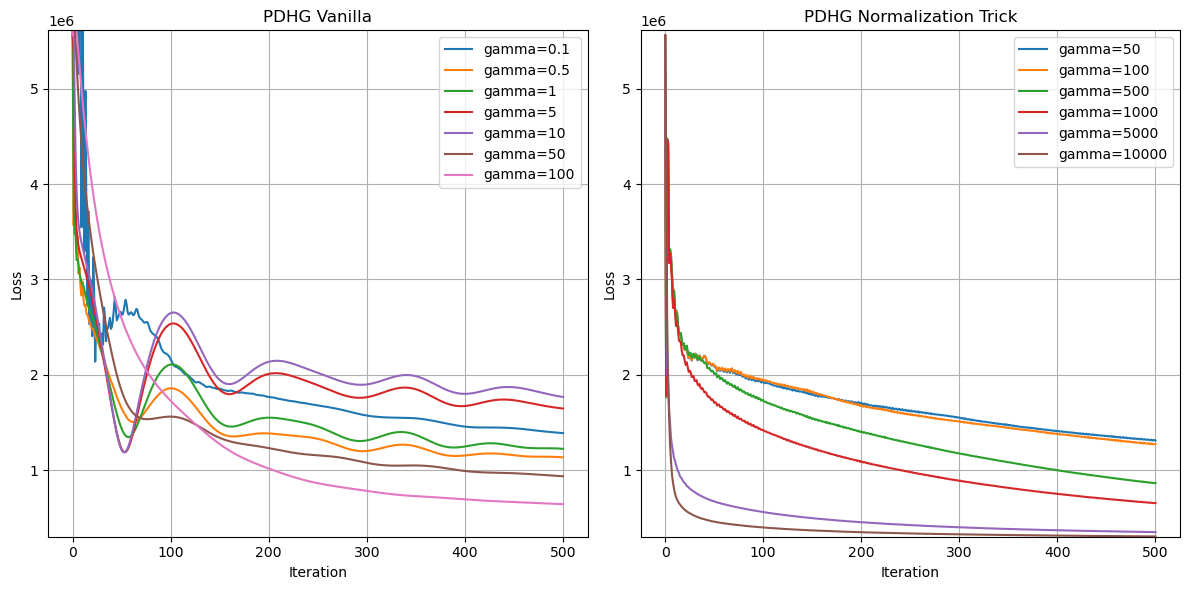

In [74]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ylow = 0.99*torch.min(obj_pdhg_norm)
yhigh = 1.01*obj_pdhg_norm[0][0]
for i in range(len(gammas)):
    ax[0].plot(obj_pdhg[i], label=f'gamma={gammas[i]}')
ax[0].set_title('PDHG Vanilla')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([ylow,yhigh])
ax[0].grid(':')

for i in range(len(gammas_norm)):
    ax[1].plot(obj_pdhg_norm[i], label=f'gamma={gammas_norm[i]}')
ax[1].set_title('PDHG Normalization Trick')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].set_ylim([ylow,yhigh])
ax[1].grid(':')
plt.tight_layout()

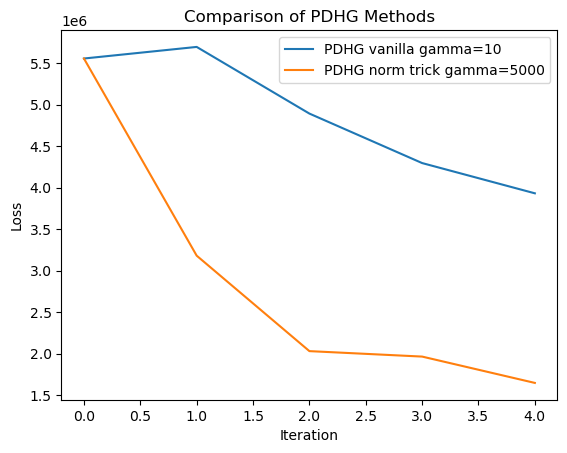

In [75]:
plt.plot(obj_pdhg[-3][0:5],label=f'PDHG vanilla gamma={gammas[-3]}')
plt.plot(obj_pdhg_norm[-2][0:5],label=f'PDHG norm trick gamma={gammas_norm[-2]}')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Comparison of PDHG Methods')
plt.legend()

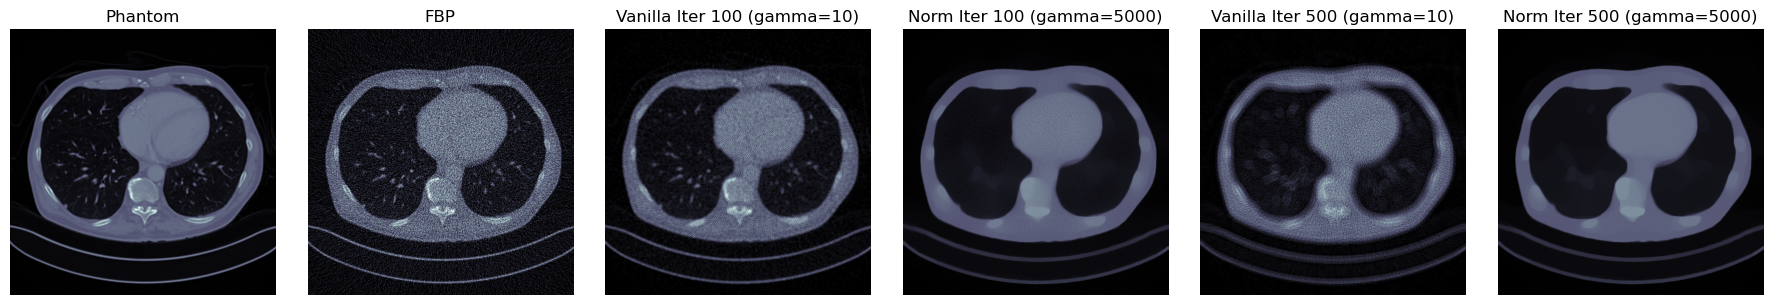

In [76]:
fig, ax = plt.subplots(1,6, figsize=(18, 3))
ax[0].imshow(phantom[0][0].cpu().numpy(), cmap='bone',vmin=0, vmax=1)
ax[0].set_title('Phantom')
ax[0].axis('off')
ax[1].imshow(fbp[0][0].cpu().numpy(), cmap='bone',vmin=0, vmax=1)
ax[1].set_title('FBP')
ax[1].axis('off')
ax[2].imshow(pdhg_x100[-3][0][0], cmap='bone',vmin=0, vmax=1)
ax[2].set_title(f'Vanilla Iter 100 (gamma={gammas[-3]})')
ax[2].axis('off')
ax[3].imshow(pdhg_norm_x100[-2][0][0], cmap='bone',vmin=0, vmax=1)
ax[3].set_title(f'Norm Iter 100 (gamma={gammas_norm[-2]})')
ax[3].axis('off')
ax[4].imshow(pdhg_x[-3][0][0], cmap='bone',vmin=0, vmax=1)
ax[4].set_title(f'Vanilla Iter {num_iter} (gamma={gammas[-3]})')
ax[4].axis('off')
ax[5].imshow(pdhg_norm_x[-2][0][0], cmap='bone',vmin=0, vmax=1)
ax[5].set_title(f'Norm Iter {num_iter} (gamma={gammas_norm[-2]})')
ax[5].axis('off')
plt.tight_layout()

In [77]:
data_function(x_pdhg, data)

109134.734375

In [78]:
TV_reg(x_pdhg)

tensor(1964.8234, device='cuda:0')

In [79]:
70639/2660  

26.556015037593983

In [80]:
x_pdhg.shape

torch.Size([1, 1, 512, 512])

In [81]:
512*512

262144